In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random, nn, lax
import matplotlib.pyplot as plt
from backend import *
import numpy as np
import time

In [2]:
# inner loop
train_episodes = 100
tmax = 300

actor_eta = 0.005

goalsize = 0.05
startcoord = [[-0.8,-0.8], [0.8,0.8]]
goalcoord = jnp.array([0.0,0.0])

seed = 2021
maxspeed = 0.1

# outer loop
envsize=1
ndim = 2
npc = 21
sigma = 0.25
nact = 2

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-06-03 14:59:10.558230: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [3]:
def get_features(npc, envsize):
    # get feature centers for 2D env
    x = jnp.linspace(-envsize,envsize,npc)
    xx,yy = jnp.meshgrid(x,x)
    lambdas = jnp.concatenate([xx.reshape(-1)[:,None],yy.reshape(-1)[:,None]],axis=1)
    return lambdas, sigma

def predict_features(pc_params, x):
    lambdas, sigma = pc_params
    exponent = np.sum(((x-lambdas)/sigma)**2,axis=1)
    pcact = jnp.exp(-exponent/2)
    return pcact

def get_params(ndim, npc, seed):
    # get state transtion matrix
    a_mat = jnp.eye(ndim)  # orthogonal transitions

    # get random policy
    b_key = random.PRNGKey(seed)
    b_mat = 1e-3 * random.normal(b_key, (ndim,npc**2))
    return [a_mat, b_mat]  


def predict_nextstate_action(params,pc_params, x, rloc):
    pc = predict_features(pc_params, x)
    # A - fix/learn state transition, B - learn policy 
    A, B  = params
    action =  B @ pc
    nextstate = A @ (rloc - x) + action
    return nextstate, action

predict_nextstate_action_vmap = vmap(predict_nextstate_action, in_axes=(None, None, 0, None))

def loss(params,pc_params, x, x_next, rloc):
    x_preds, actions = predict_nextstate_action_vmap(params,pc_params, x, rloc)
    return jnp.mean((x_next - x_preds) ** 2)

@jit
def update(params, pc_params, coords,rloc, learning_rate):
    x = coords[:-1]
    x_next = coords[1:]
    grads = grad(loss, argnums=0, has_aux=False)(params, pc_params, x, x_next,rloc)
    A, B = params
    A -= learning_rate * grads[0]
    B -= learning_rate * grads[1]
    return (A, B), np.mean(grads[0])

In [4]:
params = get_params(ndim, npc, seed)
pc_params = get_features(npc, envsize)

In [5]:
# inner loop training loop
def run_trial(params, env):
    coords = []
    actions = []
    rewards = []
    errors = []

    state, goal, eucdist, done = env.reset()

    for i in range(tmax):

        nextstate, velocity = predict_nextstate_action(params,pc_params, state, goalcoord)

        newstate, eucdist, done = env.step(velocity) 

        reward = int(done)

        coords.append(state)
        actions.append(velocity)
        rewards.append(reward)
        errors.append(np.mean((newstate - nextstate) ** 2))

        state = newstate.copy()

        if done:
            break

    return jnp.array(coords), jnp.array(rewards), jnp.array(actions),jnp.array(errors), i

In [6]:
latencys = []
errors = []
params_t = []

env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax)

for t in range(train_episodes):

    coords, rewards, actions,error_t, latency = run_trial(params, env)
    
    params, error = update(params, pc_params, coords, goalcoord, actor_eta)
    
    latencys.append(latency)
    errors.append(error)
    
    print(f"Trial {t+1}/{train_episodes}, latency {latency}, error {error}")

[[-0.8, -0.8], [0.8, 0.8]]
Trial 1/100, latency 299, error 1.2725934982299805
Trial 2/100, latency 299, error 1.823826789855957
Trial 3/100, latency 299, error 1.7336699962615967
Trial 4/100, latency 299, error 1.6234245300292969
Trial 5/100, latency 299, error 1.5928467512130737
Trial 6/100, latency 299, error 1.6491647958755493
Trial 7/100, latency 299, error 1.774251937866211
Trial 8/100, latency 299, error 1.6950386762619019
Trial 9/100, latency 299, error 1.443426489830017
Trial 10/100, latency 299, error 1.5991144180297852
Trial 11/100, latency 299, error 1.261069416999817
Trial 12/100, latency 299, error 1.4510316848754883
Trial 13/100, latency 299, error 1.2666600942611694
Trial 14/100, latency 299, error 1.3448688983917236
Trial 15/100, latency 299, error 0.9915429353713989
Trial 16/100, latency 299, error 1.3764994144439697
Trial 17/100, latency 299, error 0.9703212976455688
Trial 18/100, latency 299, error 1.1806557178497314
Trial 19/100, latency 299, error 0.953174710273742

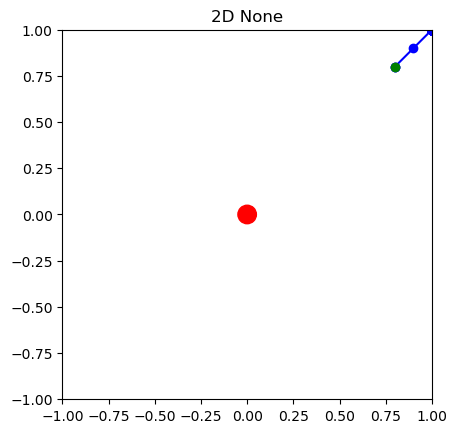

In [25]:
env.plot_trajectory()

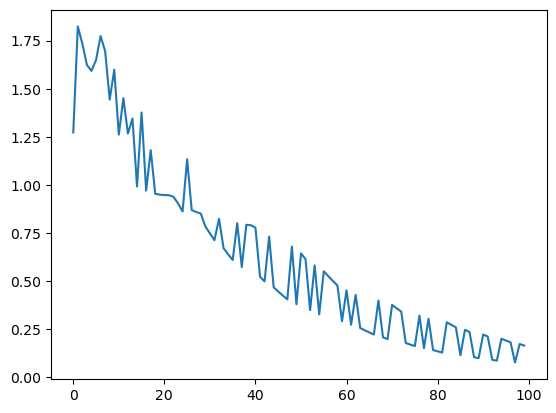

In [8]:
plt.figure()
plt.plot(errors)


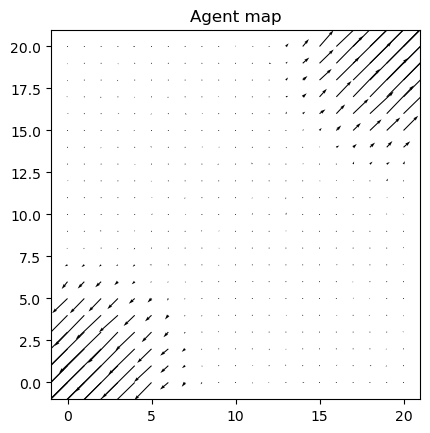

In [21]:
plot_maps(env, npc, params[1],critic_weights=None, title='Agent map')